**Ładowanie danych i preprocessing**


In [40]:
#importy
import pickle
import abc
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from sklearn.metrics import f1_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn

In [ ]:
# Wczytanie zbioru danych
dataset_path = 'drive/My Drive/dataset.pkl'

with open(dataset_path, 'rb') as f:
    dataset = pickle.load(f)

def load_x_y(ds_type):
    images = dataset[ds_type]['X']
    labels = dataset[ds_type]['y']
    return images, labels

# Ustawienie ziarna
tf.random.set_seed(1234)
def data_preprocessing(images, labels):
    # Zmiana rozmiaru obrazu z 224x224 do 64x64
    images = tf.image.resize(
        images, [64, 64], 
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR, 
        preserve_aspect_ratio=False,
        name=None
    )
    # Spłaszczenie obrazu do jednego wymiaru (np. z 64x64x3 do 12288)
    #images = tf.reshape(images, [images.shape[0],-1])
    # Zmiana typu obrazów z int na float i normalizacja wartości pikseli z przedziału 0-255 do przedziału 0-1
    images = tf.cast(images, tf.float32) / 255.0
    # Zmiana wymiarowości z [8870] na [8870, 1] w celu zastosowania `SparseCategoricalCrossentropy`
    labels = tf.reshape(labels, [-1, 1])
    
    return images, labels

# Do iterowania zbioru danych i podzielenia na paczki (ang. batch) można wykorzystać interfejs zdefiniowany w `tensorflow.data.Dataset`
def create_ds(images, labels, batch_size=100):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels)) 
    dataset = dataset.shuffle(buffer_size=len(images)).batch(batch_size=batch_size)
    return dataset

In [ ]:
images_train, labels_train = load_x_y('train')
images_train, labels_train = data_preprocessing(images_train, labels_train)
train_ds = create_ds(images_train, labels_train)

images_test_before, labels_test = load_x_y('test')
images_test, labels_test = data_preprocessing(images_test_before, labels_test)
test_ds = create_ds(images_test, labels_test)

images_val, labels_val = load_x_y('validation')
images_val, labels_val = data_preprocessing(images_val, labels_val)
val_ds = create_ds(images_val, labels_val)

**Rozwiązanie - architektura sieci**

In [ ]:
class CNN(tf.keras.Model):
    def __init__(self,kernel_size, pool_size, pooling = tf.keras.layers.MaxPooling2D):
        super(CNN, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=64, activation='relu',kernel_size=kernel_size, strides=(1, 1), 
                                            input_shape=(64, 64, 3))
        self.max_pool1 = pooling(pool_size=pool_size, strides=(2, 2))
        self.conv2 = tf.keras.layers.Conv2D(filters=64, activation='relu',kernel_size=kernel_size, strides=(1, 1))
        self.max_pool2 = pooling(pool_size=pool_size, strides=(2, 2))
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(units=384, activation='relu')
        self.fc2 = tf.keras.layers.Dense(units=192, activation='relu')
        self.fc3 = tf.keras.layers.Dense(units=14, activation='softmax')
        
    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = self.max_pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
    
    def fit(self, **kwargs):
        self.epoch_loss_train = []
        self.epoch_f1_train = []
        self.epoch_loss_val = []
        self.epoch_f1_val = []
        self.epoch_loss_test = []
        self.epoch_f1_test = []
        train_ds = kwargs.get("train_ds", None)
        batch_size = kwargs.get("batch_size", 100)
        lr = kwargs.get("lr", 0.001)
        epoch_num = kwargs.get("epoch_num", 25)
        optimizer = kwargs.get("optimizer", tf.keras.optimizers.Adam)
        optimizer = optimizer(learning_rate=lr)
        cost_func = kwargs.get('cost_func', tf.keras.losses.SparseCategoricalCrossentropy())
        val_ds = kwargs.get("val_ds", None)
        test_ds = kwargs.get("test_ds", None)
        for epoch in range(epoch_num):
            print("\nStart of epoch %d" % (epoch,))
            f1_train = tfa.metrics.F1Score(num_classes=14, average="macro")
            f1_val = tfa.metrics.F1Score(num_classes=14, average="macro")
            f1_test = tfa.metrics.F1Score(num_classes=14, average="macro")
            #TRAIN
            for x, y in train_ds:
                with tf.GradientTape() as tape:
                    logits = self.call(x)
                    loss = cost_func(y, logits)
                grads = tape.gradient(loss, self.trainable_weights)
                optimizer.apply_gradients(zip(grads, self.trainable_weights))
                f1_train.update_state(tf.squeeze(tf.one_hot(y, depth=14)), 
                                   tf.one_hot(tf.argmax(logits, axis=-1), 
                                    depth=14))
            self.epoch_loss_train.append(loss)
            self.epoch_f1_train.append(f1_train.result())
            #TEST
            for x, y in test_ds:
                logits = self.call(x)
                loss = cost_func(y, logits)
                f1_test.update_state(tf.squeeze(tf.one_hot(y, depth=14)), 
                                   tf.one_hot(tf.argmax(logits, axis=-1), 
                                    depth=14))
            self.epoch_loss_test.append(loss)
            self.epoch_f1_test.append(f1_test.result())
            #VALIDATION
            for x, y in val_ds:
                logits = self.call(x)
                loss = cost_func(y, logits)
                f1_val.update_state(tf.squeeze(tf.one_hot(y, depth=14)), 
                                   tf.one_hot(tf.argmax(logits, axis=-1), 
                                    depth=14))
                
            self.epoch_loss_val.append(loss)
            self.epoch_f1_val.append(f1_val.result())
            print("TRAIN: Loss ={:.3f}, F1 ={:.3f}".format(self.epoch_loss_train[-1],self.epoch_f1_train[-1]))
            print("TEST: Loss ={:.3f}, F1 ={:.3f}".format(self.epoch_loss_test[-1],self.epoch_f1_test[-1]))
            print("VALIDATION: Loss ={:.3f}, F1 ={:.3f}".format(self.epoch_loss_val[-1],self.epoch_f1_val[-1]))
    

    def predict(self, x):
        logits = self.call(x)
        return logits
        

**Eksperymenty**

In [27]:
def run_experiments(epoch, lr, optimizer, batch_size, kernel_size, pool_size, pooling):
    model = CNN(kernel_size = kernel_size, pool_size = pool_size, pooling=pooling)
    train_ds = create_ds(images_train, labels_train, batch_size)
    val_ds = create_ds(images_val, labels_val)
    test_ds = create_ds(images_test, labels_test, batch_size)
    model.fit(train_ds = train_ds, test_ds = test_ds, val_ds = val_ds, epoch_num = epoch, lr = lr, optimizer = optimizer, batch_size = batch_size)
    y_pred = model.predict(images_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = labels_test
    f1 = f1_score(y_true, y_pred, average='micro')
    print("PARAMS: ", epoch, lr, optimizer, batch_size, kernel_size, pool_size, pooling)
    print("LOSS: {:.3f}".format(model.epoch_loss_train[-1]))
    print("F1:", f1)
    return model, f1

In [ ]:
#Experiments params
epoch_num = [10, 30, 50]
lr_values = [0.0001, 0.001, 0.01]
optimizer = [tf.keras.optimizers.Adam, tf.keras.optimizers.SGD]
batch_size = [50, 100]
kernel_size = [(3, 3), (5,5), (7,7)]
pool_size = [(2, 2), (3, 3), (4, 4)]
pooling = [tf.keras.layers.MaxPooling2D, tf.keras.layers.AveragePooling2D]

In [ ]:
result = pd.DataFrame(columns=['epochs', 'lr', 'optimizer', 'batch_size', 'f1'])
for epoch in epoch_num:
    for lr in lr_values:
        for opt in optimizer:
            for size in batch_size:
                model, f1 = run_experiments(epoch, lr, opt, size, (5, 5), (3, 3), tf.keras.layers.MaxPooling2D)
                result = result.append({'epochs' : epoch , 'lr' : lr, 'optimizer' : opt, 'batch_size' :size, 'f1': f1}, 
                                   ignore_index=True)
with open('results.csv', 'a') as f:
    result.to_csv(f, header=False)

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
TRAIN: Loss =13.585, F1 =0.021
TEST: Loss =12.455, F1 =0.021
VALIDATION: Loss =13.096, F1 =0.021

Start of epoch 7
TRAIN: Loss =14.046, F1 =0.021
TEST: Loss =12.211, F1 =0.021
VALIDATION: Loss =13.096, F1 =0.021

Start of epoch 8
TRAIN: Loss =13.585, F1 =0.021
TEST: Loss =14.409, F1 =0.021
VALIDATION: Loss =14.103, F1 =0.021

Start of epoch 9
TRAIN: Loss =13.125, F1 =0.021
TEST: Loss =12.943, F1 =0.021
VALIDATION: Loss =12.340, F1 =0.021
PARAMS:  10 0.01 <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> 100
LOSS: 13.125
F1: 0.16790289952798382

Start of epoch 0
TRAIN: Loss =2.457, F1 =0.027
TEST: Loss =2.429, F1 =0.021
VALIDATION: Loss =2.627, F1 =0.021

Start of epoch 1
TRAIN: Loss =2.361, F1 =0.037
TEST: Loss =2.377, F1 =0.022
VALIDATION: Loss =2.549, F1 =0.022

Start of epoch 2
TRAIN: Loss =2.385, F1 =0.070
TEST: Loss =2.589, F1 =0.077
VALIDATION: Loss =2.504, F1 =0.077

Start of epoch 3
TRAIN: Loss =2.340, F1 =

Najlepsze znalezione hiperparametry: epoch = 30, lr = 0.0001, optimizer = Adam, batch_size = 100

In [28]:
result_cnn = pd.DataFrame(columns=['kernel_size', 'pool_size', 'pooling', 'f1'])
for ks in kernel_size:
    for ps in pool_size:
        for pool in pooling:
            model, f1 = run_experiments(30, 0.0001, tf.keras.optimizers.Adam, 100, ks, ps, pool)
            result_cnn = result_cnn.append({'kernel_size' : ks , 'pool_size' : ps, 'pooling' : pool, 'f1':f1}, ignore_index=True)
with open('results_cnn.csv', 'a') as f:
    result_cnn.to_csv(f, header=False)


Start of epoch 0
TRAIN: Loss =2.374, F1 =0.056
TEST: Loss =2.387, F1 =0.092
VALIDATION: Loss =2.308, F1 =0.093

Start of epoch 1
TRAIN: Loss =2.183, F1 =0.164
TEST: Loss =2.278, F1 =0.193
VALIDATION: Loss =2.314, F1 =0.188

Start of epoch 2
TRAIN: Loss =2.192, F1 =0.222
TEST: Loss =2.248, F1 =0.235
VALIDATION: Loss =2.122, F1 =0.231

Start of epoch 3
TRAIN: Loss =2.063, F1 =0.259
TEST: Loss =2.326, F1 =0.224
VALIDATION: Loss =2.331, F1 =0.209

Start of epoch 4
TRAIN: Loss =1.961, F1 =0.290
TEST: Loss =2.053, F1 =0.263
VALIDATION: Loss =2.221, F1 =0.260

Start of epoch 5
TRAIN: Loss =1.975, F1 =0.319
TEST: Loss =1.929, F1 =0.271
VALIDATION: Loss =2.021, F1 =0.267

Start of epoch 6
TRAIN: Loss =1.884, F1 =0.346
TEST: Loss =2.045, F1 =0.273
VALIDATION: Loss =2.137, F1 =0.271

Start of epoch 7
TRAIN: Loss =1.819, F1 =0.366
TEST: Loss =2.025, F1 =0.259
VALIDATION: Loss =2.101, F1 =0.276

Start of epoch 8
TRAIN: Loss =1.927, F1 =0.391
TEST: Loss =2.081, F1 =0.289
VALIDATION: Loss =1.851, F1

Najlepsze znalezione parametry sieci kernel_size = (5,5), pool_size = (4,4), pooling = MaxPooling2D

In [31]:
model, f1 = run_experiments(30, 0.0001, tf.keras.optimizers.Adam, 100, (5,5), (4,4), tf.keras.layers.MaxPooling2D)


Start of epoch 0
TRAIN: Loss =2.436, F1 =0.052
TEST: Loss =2.395, F1 =0.095
VALIDATION: Loss =2.229, F1 =0.088

Start of epoch 1
TRAIN: Loss =2.253, F1 =0.138
TEST: Loss =2.416, F1 =0.170
VALIDATION: Loss =2.267, F1 =0.173

Start of epoch 2
TRAIN: Loss =2.107, F1 =0.190
TEST: Loss =2.340, F1 =0.204
VALIDATION: Loss =2.288, F1 =0.218

Start of epoch 3
TRAIN: Loss =1.906, F1 =0.229
TEST: Loss =2.408, F1 =0.229
VALIDATION: Loss =2.080, F1 =0.230

Start of epoch 4
TRAIN: Loss =2.005, F1 =0.259
TEST: Loss =2.099, F1 =0.251
VALIDATION: Loss =1.891, F1 =0.248

Start of epoch 5
TRAIN: Loss =2.053, F1 =0.278
TEST: Loss =2.027, F1 =0.246
VALIDATION: Loss =2.214, F1 =0.239

Start of epoch 6
TRAIN: Loss =1.927, F1 =0.289
TEST: Loss =2.078, F1 =0.229
VALIDATION: Loss =2.202, F1 =0.239

Start of epoch 7
TRAIN: Loss =1.799, F1 =0.312
TEST: Loss =2.146, F1 =0.268
VALIDATION: Loss =1.747, F1 =0.272

Start of epoch 8
TRAIN: Loss =2.023, F1 =0.336
TEST: Loss =2.091, F1 =0.257
VALIDATION: Loss =2.033, F1

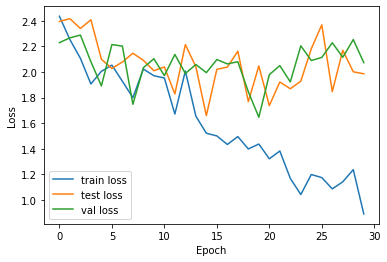

In [38]:
plt.plot(model.epoch_loss_train, label = 'train loss')
plt.plot(model.epoch_loss_test, label = 'test loss')
plt.plot(model.epoch_loss_val, label = 'val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower left')

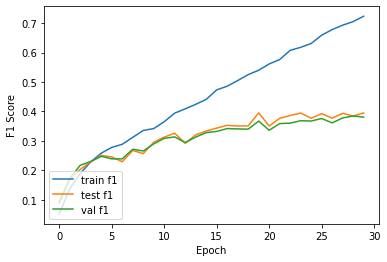

In [39]:
plt.plot(model.epoch_f1_train, label = 'train f1')
plt.plot(model.epoch_f1_test, label = 'test f1')
plt.plot(model.epoch_f1_val, label = 'val f1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(loc='lower left')

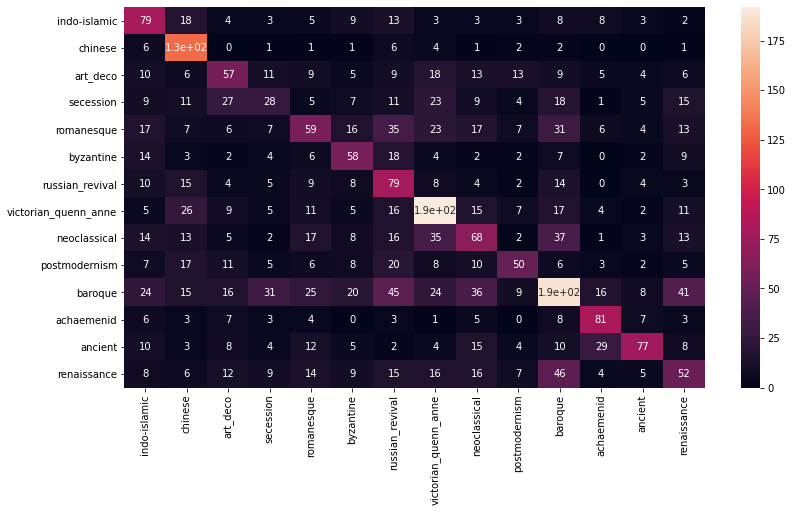

In [41]:
labels = list(dataset['labels_mapping'].keys())
y_pred = model.predict(images_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = labels_test
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (13,7))
sn.heatmap(df_cm, annot=True)

In [42]:
def show_image(image, correct, predicted):
    plt.imshow(image)
    plt.title(f'Correct: {correct} Predicted: {predicted}')
    plt.show()

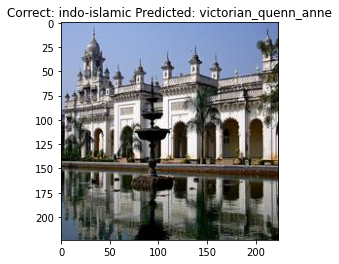

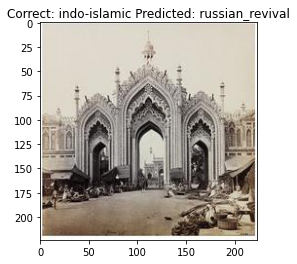

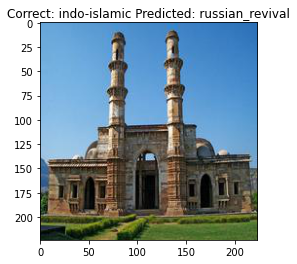

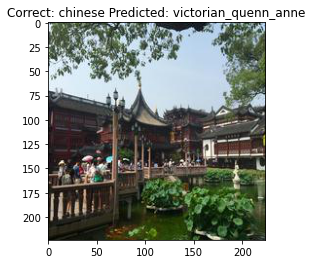

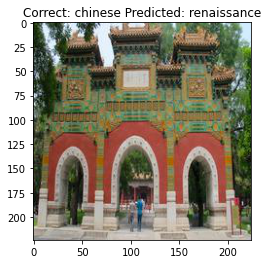

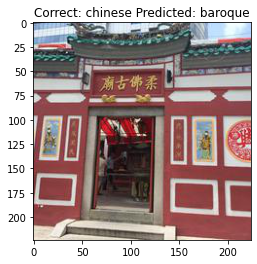

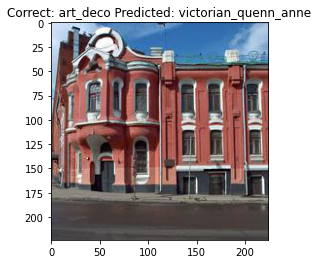

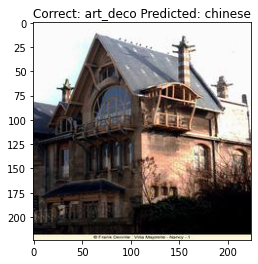

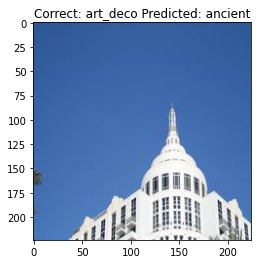

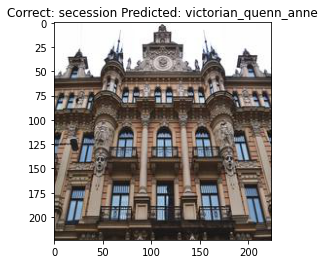

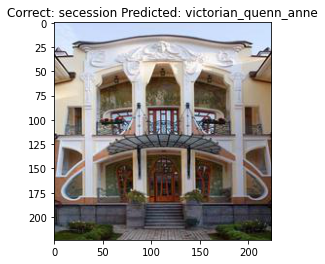

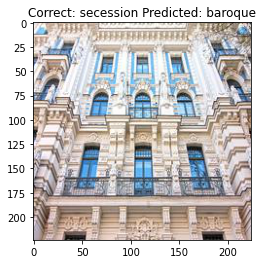

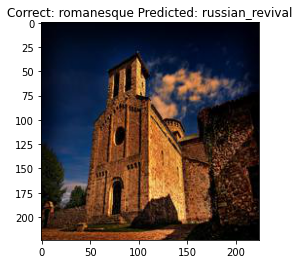

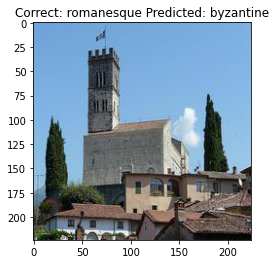

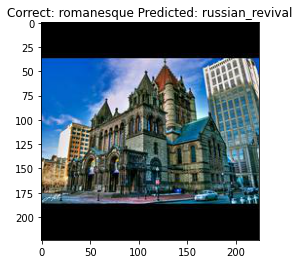

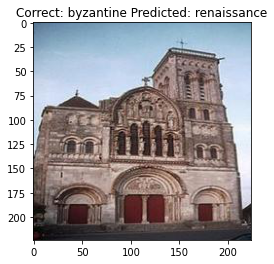

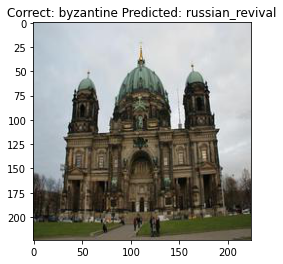

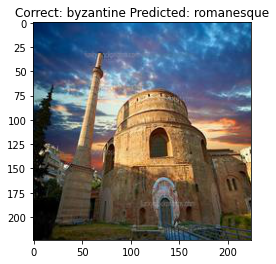

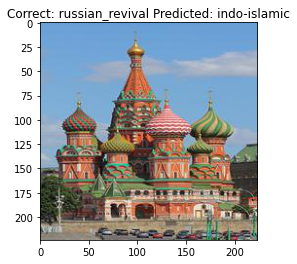

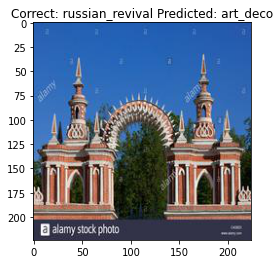

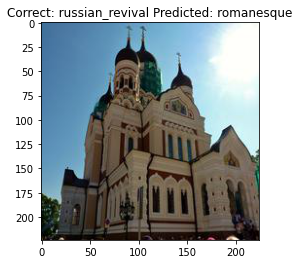

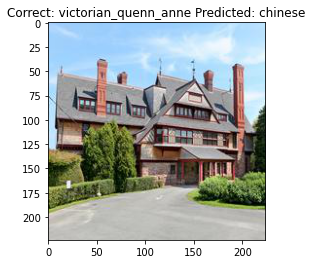

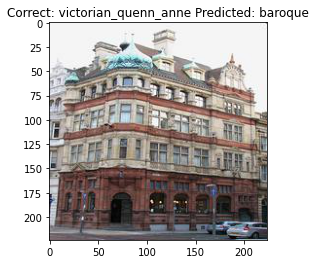

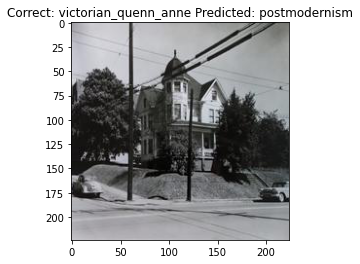

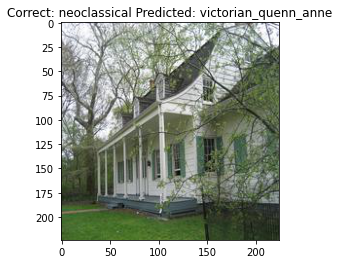

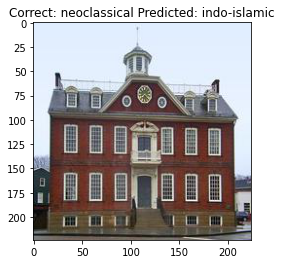

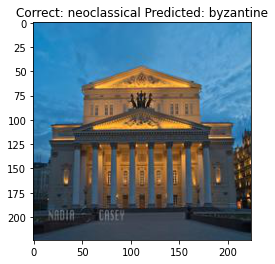

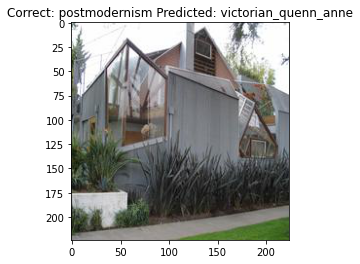

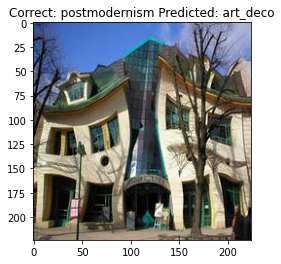

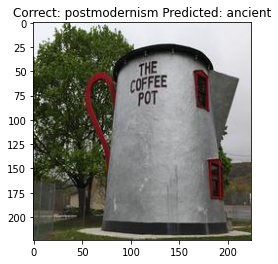

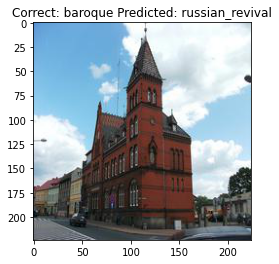

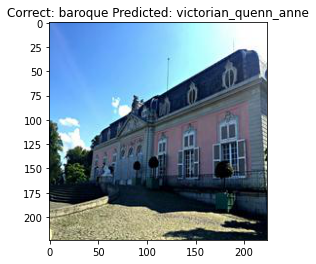

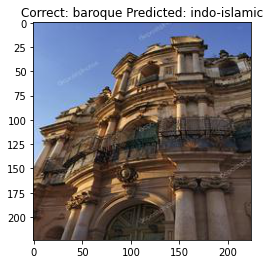

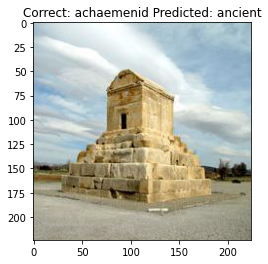

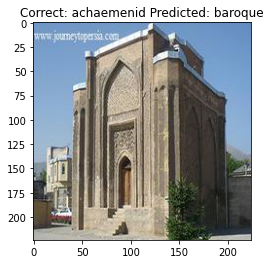

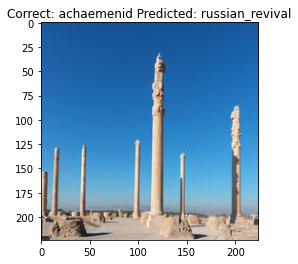

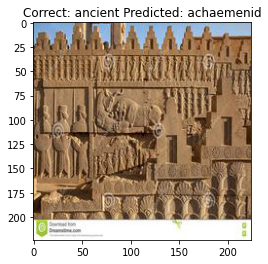

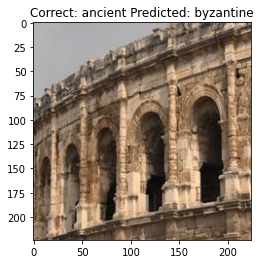

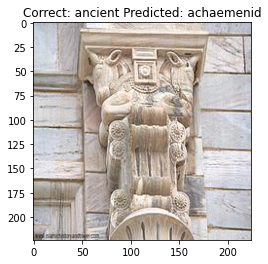

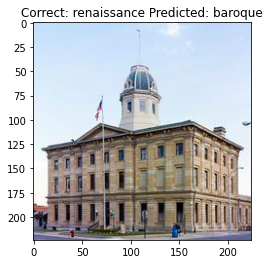

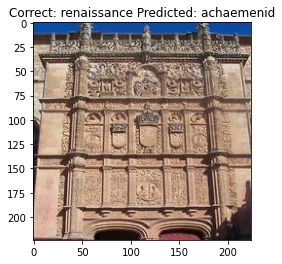

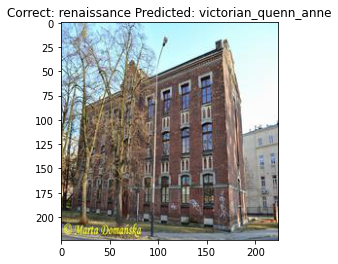

In [45]:
y_pred = model.predict(images_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = labels_test
labels = list(dataset['labels_mapping'].keys())
for c in range(14):
    count = 0
    for x, y_p, y_t in zip(images_test_before, y_pred, y_true):
        y_t = y_t.numpy()[0]
        if y_t == c:
            if (y_p != y_t) and count<3:
                count +=1
                show_image(x,labels[y_t],labels[y_p])

### Podsumowanie

Sieć daje lepsze wyniki niż sieć z MLP. 
W przypadku wielu testowanych hiperparametrów następował overfitting. 
Najlepsze wyniki (F_Score ok. 40%) osiągnięto dla następującego zestawu hiperparametrów: 
- epoch = 30, lr = 0.0001, optimizer = Adam, batch_size = 100
oraz parametrów sieci: 
- kernel_size = (5,5), pool_size = (4,4), pooling = MaxPooling2D

Wiele przykładowych pomyłek jest takich samych jak w sieci MLP.

Porównanie:
- FScore dla podstawowej architektury sieci zdefiniowanej w zadaniu 0.388
- Najlepszy FScore 0.408 po dostrojeniu parametrów
